### This notebook includes the basic joint GCS and PCS using Gumbel-softmax differentiable sampling technique. Initialization with a known constellation is required when bit metric decoding is used. In this notebook we add PAS constraint, upsampling, filtering and PAPR.

In [1]:
%reset

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, LayerNormalization
from tensorflow.nn import relu
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
import sionna as sn
import matplotlib.pyplot as plt
import os
import gc

In [3]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

1


In [4]:
symbol_points_qam64 = np.array([-1.08012344973464 + 1.08012344973464j
,-1.08012344973464 + 0.771516749810460j
,-1.08012344973464 + 0.154303349962092j
,-1.08012344973464 + 0.462910049886276j
,-0.771516749810460 + 1.08012344973464j
,-0.771516749810460 + 0.771516749810460j
,-0.771516749810460 + 0.154303349962092j
,-0.771516749810460 + 0.462910049886276j
,-0.154303349962092 + 1.08012344973464j
,-0.154303349962092 + 0.771516749810460j
,-0.154303349962092 + 0.154303349962092j
,-0.154303349962092 + 0.462910049886276j
,-0.462910049886276 + 1.08012344973464j
,-0.462910049886276 + 0.771516749810460j
,-0.462910049886276 + 0.154303349962092j
,-0.462910049886276 + 0.462910049886276j
,-1.08012344973464 - 1.08012344973464j
,-1.08012344973464 - 0.771516749810460j
,-1.08012344973464 - 0.154303349962092j
,-1.08012344973464 - 0.462910049886276j
,-0.771516749810460 - 1.08012344973464j
,-0.771516749810460 - 0.771516749810460j
,-0.771516749810460 - 0.154303349962092j
,-0.771516749810460 - 0.462910049886276j
,-0.154303349962092 - 1.08012344973464j
,-0.154303349962092 - 0.771516749810460j
,-0.154303349962092 - 0.154303349962092j
,-0.154303349962092 - 0.462910049886276j
,-0.462910049886276 - 1.08012344973464j
,-0.462910049886276 - 0.771516749810460j
,-0.462910049886276 - 0.154303349962092j
,-0.462910049886276 - 0.462910049886276j
,1.08012344973464 + 1.08012344973464j
,1.08012344973464 + 0.771516749810460j
,1.08012344973464 + 0.154303349962092j
,1.08012344973464 + 0.462910049886276j
,0.771516749810460 + 1.08012344973464j
,0.771516749810460 + 0.771516749810460j
,0.771516749810460 + 0.154303349962092j
,0.771516749810460 + 0.462910049886276j
,0.154303349962092 + 1.08012344973464j
,0.154303349962092 + 0.771516749810460j
,0.154303349962092 + 0.154303349962092j
,0.154303349962092 + 0.462910049886276j
,0.462910049886276 + 1.08012344973464j
,0.462910049886276 + 0.771516749810460j
,0.462910049886276 + 0.154303349962092j
,0.462910049886276 + 0.462910049886276j
,1.08012344973464 - 1.08012344973464j
,1.08012344973464 - 0.771516749810460j
,1.08012344973464 - 0.154303349962092j
,1.08012344973464 - 0.462910049886276j
,0.771516749810460 - 1.08012344973464j
,0.771516749810460 - 0.771516749810460j
,0.771516749810460 - 0.154303349962092j
,0.771516749810460 - 0.462910049886276j
,0.154303349962092 - 1.08012344973464j
,0.154303349962092 - 0.771516749810460j
,0.154303349962092 - 0.154303349962092j
,0.154303349962092 - 0.462910049886276j
,0.462910049886276 - 1.08012344973464j
,0.462910049886276 - 0.771516749810460j
,0.462910049886276 - 0.154303349962092j
,0.462910049886276 - 0.462910049886276j])

In [5]:
def normalize_constellation(points, probabilities):

    # Compute the power of the constellation
    power = np.sum(probabilities * np.abs(points)**2)
    # Normalize the constellation points
    normalized_points = points / np.sqrt(power)
    return normalized_points

def plot_constellation_wlabels(points, probabilities, plot_title):

    points = np.asarray(points)
    probabilities = np.asarray(probabilities).flatten()

    # Scale marker sizes for visibility
    marker_sizes = 300 * probabilities / max(probabilities)

    plt.figure(figsize=(8, 8))
    plt.scatter(points.real, points.imag, s=marker_sizes, alpha=0.7, c='b', edgecolors='k')

    # Annotate with 6-bit binary labels
    for i, pt in enumerate(points):
        label = format(i, '06b')  # 6-bit binary string
        plt.text(pt.real + 0.05, pt.imag + 0.05, label, fontsize=9, ha='left', va='bottom', color='darkred')

    # Add grid and formatting
    plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.grid(True, linestyle=':')
    plt.xlabel("In-phase")
    plt.ylabel("Quadrature")
    plt.title(plot_title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    # plt.show()


In [6]:
class Modulator(Layer):

    def __init__(self, constellation, N,  parity_k, **kwargs):
        super(Modulator, self).__init__(**kwargs)

        # Define the real and imaginary parts of the constellation as trainable variables
        # self.constellation_real = tf.Variable(constellation.real, dtype=tf.float32, trainable=True)
        # self.constellation_imag = tf.Variable(constellation.imag, dtype=tf.float32, trainable=True)
        self.constellation_real_init = constellation.real
        self.constellation_imag_init = constellation.imag
        self.parity_k = parity_k
        self.N = N

    def build(self, input_shape):
        self.constellation_real = self.add_weight(
            name="constellation_real",
            shape=self.constellation_real_init.shape,
            initializer=tf.constant_initializer(self.constellation_real_init),
            trainable=True
        )
        self.constellation_imag = self.add_weight(
            name="constellation_imag",
            shape=self.constellation_imag_init.shape,
            initializer=tf.constant_initializer(self.constellation_imag_init),
            trainable=True
        )

    def call(self, s, probabilities):
        # Combine the real and imaginary parts into a complex-valued constellation
        constellation_combined = tf.complex(self.constellation_real, self.constellation_imag)

        # Expand the signal dimension to align for matrix multiplication
        s = tf.expand_dims(s, axis=-1)

        # Normalize the constellation
        normalization_constants = tf.sqrt(
            tf.reduce_sum(tf.reshape((2**parity_k)*probabilities * tf.abs(constellation_combined) ** 2,(1,(2**self.parity_k),int(self.N/(2**self.parity_k)))), 2)
        )
        normalization_constants = tf.expand_dims(normalization_constants, axis=2)
        normalization_constants = tf.complex(tf.reshape(tf.tile(normalization_constants,(1,1,int(self.N/(2**self.parity_k)))),(1,self.N)),0.0)
        norm_constellation = constellation_combined / normalization_constants

        # print('norm_constellation',norm_constellation.shape)
        # print('s',s.shape)
        # Compute the modulated signal
        x_real = tf.matmul(tf.math.real(norm_constellation), s)
        x_imag = tf.matmul(tf.math.imag(norm_constellation), s)
        x = tf.complex(x_real, x_imag)

        return tf.squeeze(x, axis=[-1, -2])

In [7]:
class Demodulator_bitwise(Layer):
    def __init__(self, bits_per_symbol):
        super(Demodulator_bitwise, self).__init__()
        self.dense1 = Dense(128, activation='relu')  # First Dense Layer
        self.dense2 = Dense(128, activation='relu')  # Second Dense Layer
        self.dense3 = Dense(bits_per_symbol, activation='sigmoid')                      # Output Dense Layer
        # self.snr_db = snr_db                        # SNR in dB

    def call(self, y, batch_size, block_size):
        # Ensure complex-valued input is split into real and imaginary parts
        y_real = tf.math.real(y)
        y_imag = tf.math.imag(y)

        # Create and broadcast SNR tensor
        snr_tensor = tf.constant([[1]], dtype=tf.float32)
        brd_snr_tensor = tf.broadcast_to(snr_tensor, [batch_size, block_size, 1])

        # Concatenate real, imaginary, and SNR tensors along the last dimension
        y_real = tf.expand_dims(y_real,axis=-1)
        y_imag = tf.expand_dims(y_imag,axis=-1)
        # print('y_real',y_real.shape)
        # print('y_imag',y_imag.shape)
        # print('brd_snr_tensor',brd_snr_tensor.shape)
        stack_input = tf.concat([y_real, y_imag, brd_snr_tensor], axis=2)

        ## print('brd_snr_tensor.shape: ',brd_snr_tensor)

        # Pass the stacked input through the dense layers
        x = self.dense1(stack_input)
        x = self.dense2(x)
        logits = self.dense3(x)

        return logits

In [8]:
class SamplingMechanism(Layer):
    def __init__(self, N, tau, parity_k):
        super(SamplingMechanism, self).__init__()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(int(N/(2**parity_k)), activation=None)
        self.tau = tau
        # self.snr_db = snr_db
        self.parity_k = parity_k
        self.N = N

    def call(self, batch_size, block_size):
        # Create a tensor with the SNR value
        snr_tensor = tf.constant([[1]], dtype=tf.float32)
        # Pass the SNR value through the first dense layer
        a = self.dense1(snr_tensor)

        # Pass through the second dense layer
        logits = self.dense2(a)
        # print('1',logits.shape)
        #
        # Copying the logits 2**parity_k times to constrain according to PAS
        logits = tf.tile(logits, [1, 2**self.parity_k])
        # print('2',logits.shape)

        # Compute softmax output
        softmax_out = tf.nn.softmax(logits, axis=-1)

        logits = tf.expand_dims(logits, axis=1)
        # print('3',logits.shape)
        logits = tf.tile(logits, [batch_size, block_size, 1])

        # Compute Gumbel-Softmax with straight-through sampling
        gumbel_dist = -tf.math.log(-tf.math.log(tf.random.uniform(tf.shape(logits), 0, 1) + 1e-20) + 1e-20)
        gumbel_logits = logits + gumbel_dist
        gumbel_softmax = tf.nn.softmax(gumbel_logits / self.tau, axis=-1)

        max_value = tf.argmax(gumbel_softmax, axis=-1)
        # print(gumbel_softmax.shape)

        # Step 2: Compare each value in gumbel_softmax with the max_value
        hard_sample = tf.one_hot(max_value, depth=self.N, dtype=tf.float32)
        # print("hard_sample:", hard_sample)

        straight_through = gumbel_softmax + tf.stop_gradient(hard_sample - gumbel_softmax)

        return straight_through, softmax_out



In [9]:
class EndToEndSystem_bitwise(Model):
    def __init__(self, N, constellation, batch_size, block_size, bits_per_symbol, parity_k, use_upsampling_filtering, tau=1.0):
        super(EndToEndSystem_bitwise, self).__init__()
        # self.No = 1/(10**(snr_db/10))
        self.sampling = SamplingMechanism(N, tau, parity_k)
        self.batch_size = batch_size
        self.block_size = block_size
        self.papr_batch_size = batch_size
        self.modulator = Modulator(constellation,N,parity_k)
        self.channel = sn.phy.channel.AWGN()
        self.demodulator = Demodulator_bitwise(bits_per_symbol)
        self.loss_fn = BinaryCrossentropy(from_logits=False, reduction='none', axis=[0, 1])
        self.bits_per_symbol = bits_per_symbol
        self.parity_k = parity_k
        self.use_upsampling_filtering = use_upsampling_filtering
        self.upsampler = sn.phy.signal.Upsampling(samples_per_symbol=4)
        self.tx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                         samples_per_symbol=4,
                                                         span_in_symbols=32)
        self.rx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                         samples_per_symbol=4,
                                                         span_in_symbols=32)
        self.downsampler = sn.phy.signal.Downsampling(samples_per_symbol=4,
                                                      offset = self.rx_filter.length - 1,

                                                 num_symbols=tf.cast(block_size, tf.int32))
    def call(self, No):
        # Sampling mechanism generates symbol indices and shaping probabilities

        s, shaping_probs = self.sampling(batch_size = self.batch_size, block_size = self.block_size)
        indices = tf.argmax(s, axis=2, output_type=tf.int64)  # use int64 here!
        # Step 2: Convert to binary bits
        shifts = tf.range(self.bits_per_symbol - 1, -1, -1, dtype=tf.int64)  # also int64
        # Right shift and mask
        bit_repr = tf.bitwise.right_shift(
            tf.expand_dims(indices, -1), shifts
        ) & 1

        # Modulate the symbols
        x_mod = self.modulator(s, shaping_probs)

        if self.use_upsampling_filtering:
            x_up = self.upsampler(x_mod)
            x_tx_filt = self.tx_filter(x_up)
            y_channel = self.channel(x_tx_filt, No)
            y_rx_filt = self.rx_filter(y_channel)
            y = self.downsampler(y_rx_filt)
        else:
            # Transmit through the channel
            y = self.channel(x_mod, No)

        # Demodulate the received signal
        logits = self.demodulator(y, batch_size = self.batch_size, block_size = self.block_size)

        loss_ordinary = tf.reduce_sum(self.loss_fn(bit_repr,logits))
        entropy_value = -tf.reduce_sum(shaping_probs * tf.math.log(shaping_probs))
        loss = loss_ordinary - entropy_value

        return loss, loss_ordinary, entropy_value, shaping_probs

    @tf.function
    def compute_power_to_average_power_samples(self):
        s_power, shaping_probs_power = self.sampling( batch_size = self.papr_batch_size, block_size = self.block_size)
        x_power = self.modulator(s_power, shaping_probs_power)
        x_up_power = self.upsampler(x_power)
        x_tx_filt_power = self.tx_filter(x_up_power)  # 'same' for discarding the edges
        p_x = tf.square(tf.abs(x_tx_filt_power))
        power_samples = p_x / tf.reduce_mean(p_x)
        return power_samples

In [10]:
## Inner loop
@tf.function
def _inner_loop(lambd_papr, mu, step, num_it, excess_power_target, papr_threshold, No):
    # We need to initialize c...
    excess_power = 0.0
    c_excess_power = excess_power
    L = 0.0

    k = tf.constant(0, tf.int32)
    while tf.less(k, num_it):
        with tf.GradientTape() as tape:
            loss,loss_ordinary, entropy_value,_ = model(No)

            if use_upsampling_filtering:
                powers = model.compute_power_to_average_power_samples()
                excess_power = tf.reduce_mean(tf.nn.relu(powers[:,64:-64]  - papr_threshold))
                excess_power = tf.math.log(excess_power + 1e-12) / tf.math.log(10.)

                c_excess_power = excess_power - excess_power_target
                c_excess_power = tf.maximum(c_excess_power,lambd_papr / mu)

            # Augmented Lagrangian
            L = loss - lambd_papr * c_excess_power + 0.5 * mu * (
                tf.square(c_excess_power))

        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(L, weights)
        grads, glob_norm = tf.clip_by_global_norm(grads, 0.1)
        optimizer.apply_gradients(zip(grads, weights))
        # Print progress
        if k % 50 == 0:
          tf.print('Iteration',k,'L', L / np.log(2),'loss', loss / np.log(2), 'loss_ordinary', loss_ordinary / np.log(2), 'entropy_value', entropy_value / np.log(2),'glob_norm',glob_norm)

        k = k + 1
        step = step + 1

        if use_upsampling_filtering:
            powers = model.compute_power_to_average_power_samples()
            excess_power = tf.reduce_mean(tf.nn.relu(powers[:,64:-64]  - papr_threshold))
            excess_power = tf.math.log(excess_power + 1e-12) / tf.math.log(10.)
            c_excess_power = excess_power - excess_power_target
            c_excess_power = tf.maximum(c_excess_power,lambd_papr / mu)

    return c_excess_power, step



### One-time training

In [12]:
###############################
# Train function
###############################
N = 64  # Number of classes (symbols)
bits_per_symbol = int(np.log2(N))

parity_k = 2
use_upsampling_filtering = True  # Remove 'false' this after testing without upsampling and filtering

constellation = symbol_points_qam64

snr_db = 15  # SNR in dB

tau = 10

# Batch size
batch_size = 25
block_size = 200

model = EndToEndSystem_bitwise(N, constellation, batch_size, block_size, bits_per_symbol, parity_k, use_upsampling_filtering, tau)

No = tf.convert_to_tensor(1/(10**(snr_db/10)),tf.float32)
# _,_,_,_ = model(No)

excess_power_target = -3.5 #B
papr_threshold_db = 6.0 #dB
papr_threshold = tf.math.pow(10.0, papr_threshold_db / 10.0)
# We define a new optimizer at every rune
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Outer-loop
# Lagrange multiplier
lambd_papr = tf.Variable(tf.constant(0.0, tf.float32), trainable=False, dtype=tf.float32)

# Penalty parameter
mu = tf.Variable(0.01, trainable=False, dtype=tf.float32)

step = tf.constant(0, tf.int32)
for i in range(50):

    # Find a local minimizer (increase the first number of iterations if using random initializations)
    if i == 0:
        num_it = 5000
    else:
        num_it = 250
    c_excess_power, step = _inner_loop(lambd_papr, mu, step, num_it,
                                       excess_power_target, papr_threshold, No)

    # Update Lagrange multipliers
    tf.print('-------------------------------------------------------')
    tf.print('-------------------------------------------------------')
    tf.print('Progress ',i,' % ','c_excess_power',c_excess_power,'lambd_papr',lambd_papr,'mu',mu)
    tf.print('-------------------------------------------------------')
    tf.print('-------------------------------------------------------')
    lambd_papr = lambd_papr - mu * c_excess_power

    # Update penalty parameter
    mu = mu*1.003

I0000 00:00:1770289346.778038    5059 cuda_dnn.cc:529] Loaded cuDNN version 91400


Iteration 0 L 0.0514732786 loss 0.0495523289 loss_ordinary 6.03341818 entropy_value 5.98386574 glob_norm 0.638585269
Iteration 50 L -2.04631448 loss -2.04708576 loss_ordinary 3.92624187 entropy_value 5.97332764 glob_norm 0.490432
Iteration 100 L -3.50042343 loss -3.50101542 loss_ordinary 2.46475601 entropy_value 5.9657712 glob_norm 0.290839285
Iteration 150 L -3.92008 loss -3.92065716 loss_ordinary 2.05205536 entropy_value 5.97271252 glob_norm 0.33071357
Iteration 200 L -4.1067009 loss -4.10868835 loss_ordinary 1.83982873 entropy_value 5.94851732 glob_norm 0.488460541
Iteration 250 L -4.29772 loss -4.30353785 loss_ordinary 1.59114408 entropy_value 5.89468193 glob_norm 0.305090636
Iteration 300 L -4.48750973 loss -4.49850416 loss_ordinary 1.30737579 entropy_value 5.80587959 glob_norm 0.433810443
Iteration 350 L -4.66460943 loss -4.67788792 loss_ordinary 1.07011211 entropy_value 5.748 glob_norm 0.362071246
Iteration 400 L -4.75054502 loss -4.76587248 loss_ordinary 0.952432692 entropy_val

[[0.00747281 0.00845111 0.00831834 0.00833981 0.00852739 0.01209077
  0.01578151 0.01451036 0.00848929 0.01605102 0.03814739 0.02842476
  0.0085794  0.01505467 0.0282027  0.02355867 0.00747281 0.00845111
  0.00831834 0.00833981 0.00852739 0.01209077 0.01578151 0.01451036
  0.00848929 0.01605102 0.03814739 0.02842476 0.0085794  0.01505467
  0.0282027  0.02355867 0.00747281 0.00845111 0.00831834 0.00833981
  0.00852739 0.01209077 0.01578151 0.01451036 0.00848929 0.01605102
  0.03814739 0.02842476 0.0085794  0.01505467 0.0282027  0.02355867
  0.00747281 0.00845111 0.00831834 0.00833981 0.00852739 0.01209077
  0.01578151 0.01451036 0.00848929 0.01605102 0.03814739 0.02842476
  0.0085794  0.01505467 0.0282027  0.02355867]]
snr_15_PAPR_6.0_target_-3.5


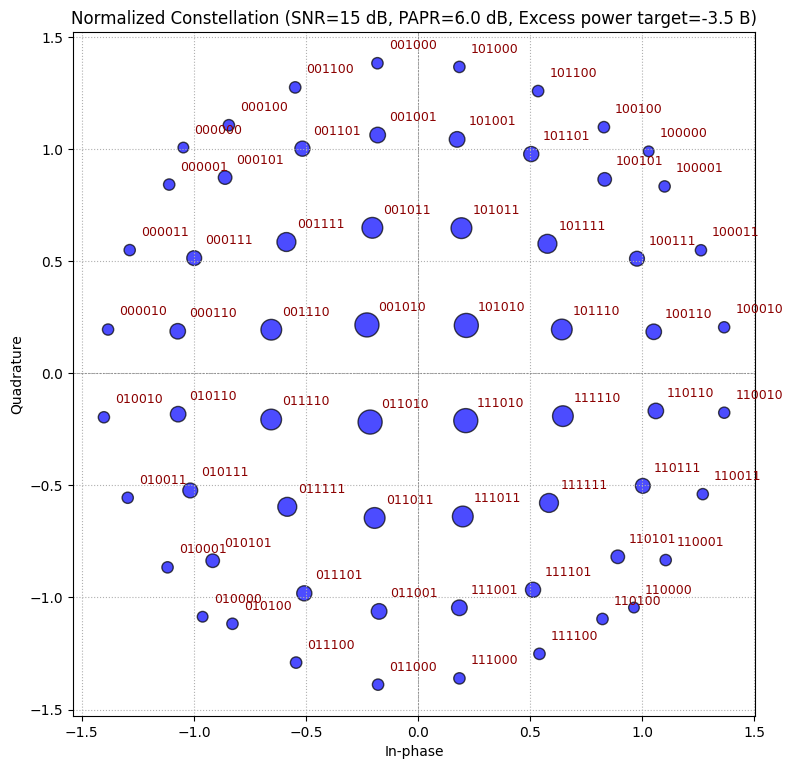

In [14]:
with tf.GradientTape(persistent=False) as tape:
#     tape.watch(model.trainable_variables)  # Ensure variables are watched if needed, but no gradients will be calculated
    _,_,_,shaping_probs = model(No)


# Define constellation points (complex numbers)
points = model.modulator.constellation_real.numpy()+ 1j*model.modulator.constellation_imag.numpy()

# Define probabilities for each point
probabilities = shaping_probs.numpy()

# plt.savefig('const.pdf')

# Normalize the constellation
normalized_points = normalize_constellation(points, probabilities)

title_plot = f"Normalized Constellation (SNR={snr_db} dB, PAPR={papr_threshold_db} dB, Excess power target={excess_power_target} B)"
# Plot the constellation
plot_constellation_wlabels(normalized_points, probabilities, title_plot)
file_name = f"snr_{snr_db}_PAPR_{papr_threshold_db}_target_{excess_power_target}"
print(probabilities)
print(file_name)


### Training for several SNR and PAPR values

In [27]:

def run_experiment(snr_db, papr_threshold_db):
    print(f"\n===== Running SNR={snr_db} dB | PAPR={papr_threshold_db} dB =====\n")

    No_ = tf.convert_to_tensor(1/(10**(snr_db/10)),tf.float32)
    papr_threshold_ = tf.math.pow(10.0, papr_threshold_db / 10.0)
    excess_power_target_ = -3.5 #B



    lambd_papr = tf.Variable(tf.constant(0.0, tf.float32), trainable=False, dtype=tf.float32)
    mu = tf.Variable(0.01, trainable=False, dtype=tf.float32)
    step = tf.constant(0, tf.int32)

    for i in range(50):
        if i == 0:
            num_it = 5000
        else:
            num_it = 500
        c_excess_power, step = _inner_loop(lambd_papr, mu, step,
                                           num_it, excess_power_target_,
                                           papr_threshold_, No_)

        # Update Lagrange multipliers
        tf.print('-------------------------------------------------------')
        tf.print('-------------------------------------------------------')
        tf.print('Progress ',i,' % ','c_excess_power',c_excess_power,'lambd_papr',lambd_papr,'mu',mu)
        tf.print('-------------------------------------------------------')
        tf.print('-------------------------------------------------------')
        lambd_papr = lambd_papr - mu * c_excess_power

        # Update penalty parameter
        mu = mu*1.003

    # ------------------
    # Save constellation
    # ------------------
    with tf.GradientTape() as tape:
        _, _, _, shaping_probs = model(No_)

    points = (
        model.modulator.constellation_real.numpy()
        + 1j * model.modulator.constellation_imag.numpy()
    )
    probs = shaping_probs.numpy()

    normalized_points = normalize_constellation(points, probs)

    exp_name = f"snr_{snr_db}_papr_{papr_threshold_db}"
    # np.save(f"{RESULTS_DIR}/{exp_name}_points.npy", normalized_points)
    # np.save(f"{RESULTS_DIR}/{exp_name}_probs.npy", probs)

    plt.figure()
    plot_constellation_wlabels(
        normalized_points,
        probs,
        f"SNR={snr_db} dB, PAPR={papr_threshold_db} dB"
    )
    plt.savefig(f"{RESULTS_DIR}/{exp_name}_constellation.png")
    plt.close()

    # ------------------
    # Compute & save CCDF
    # ------------------
    powers = tf.reshape(
        model.compute_power_to_average_power_samples(), [-1]
    )
    powers_db = 10 * tf.math.log(powers + 1e-12) / tf.math.log(10.)

    x_sorted = np.sort(powers_db.numpy())
    ccdf = 1.0 - np.arange(1, len(x_sorted) + 1) / len(x_sorted)

    np.savez(
        f"{RESULTS_DIR}/{exp_name}.npz",
        snr_db=snr_db,
        papr_db=papr_threshold_db,
        constellation_points=normalized_points,
        constellation_probabilities=probs,
        ccdf_x_db=x_sorted,
        ccdf_y=ccdf
    )


    # np.save(f"{RESULTS_DIR}/{exp_name}_ccdf_x.npy", x_sorted)
    # np.save(f"{RESULTS_DIR}/{exp_name}_ccdf_y.npy", ccdf)


    print(f"Finished {exp_name}")


In [28]:
snr_list = [13, 15, 17]
papr_list = [6.0, 7.0, 8.0]

N = 64  # Number of classes (symbols)
bits_per_symbol = int(np.log2(N))
parity_k = 2
use_upsampling_filtering = True  # Remove 'false' this after testing without upsampling and filtering
constellation = symbol_points_qam64

tau = 10
snr_db = 15
No = tf.convert_to_tensor(1/(10**(snr_db/10)),tf.float32)
# Batch size
batch_size = 25
block_size = 200
model = EndToEndSystem_bitwise(N, constellation,
                                batch_size, block_size,
                               bits_per_symbol, parity_k,
                               use_upsampling_filtering, tau)
_,_,_,_ = model(No)
initial_weights = model.get_weights()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)


for snr_db in snr_list:
    for papr_db in papr_list:
        model.set_weights(initial_weights)
        optimizer = tf.keras.optimizers.Adam(0.001)
        run_experiment(snr_db, papr_db)
        tf.keras.backend.clear_session()
        gc.collect()

print("ALL EXPERIMENTS FINISHED")



===== Running SNR=13 dB | PAPR=6.0 dB =====

Iteration 0 L 0.0203832667 loss 0.0187584907 loss_ordinary 6.00994205 entropy_value 5.99118328 glob_norm 0.632064879
Iteration 50 L -2.04581642 loss -2.04705095 loss_ordinary 3.92117763 entropy_value 5.96822834 glob_norm 0.475318789
Iteration 100 L -3.34753 loss -3.34753 loss_ordinary 2.60504293 entropy_value 5.95257282 glob_norm 0.327991843
Iteration 150 L -3.70779157 loss -3.70840478 loss_ordinary 2.24957919 entropy_value 5.95798397 glob_norm 0.302352
Iteration 200 L -3.77171421 loss -3.77321053 loss_ordinary 2.17585087 entropy_value 5.94906139 glob_norm 0.38323155
Iteration 250 L -3.83674622 loss -3.83984184 loss_ordinary 2.09005308 entropy_value 5.92989492 glob_norm 0.405189902
Iteration 300 L -3.89600182 loss -3.89901519 loss_ordinary 2.00788164 entropy_value 5.90689659 glob_norm 0.282104671
Iteration 350 L -3.92744398 loss -3.93254972 loss_ordinary 1.94035852 entropy_value 5.87290812 glob_norm 0.373495787
Iteration 400 L -4.01752329 l

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Plotting saved data

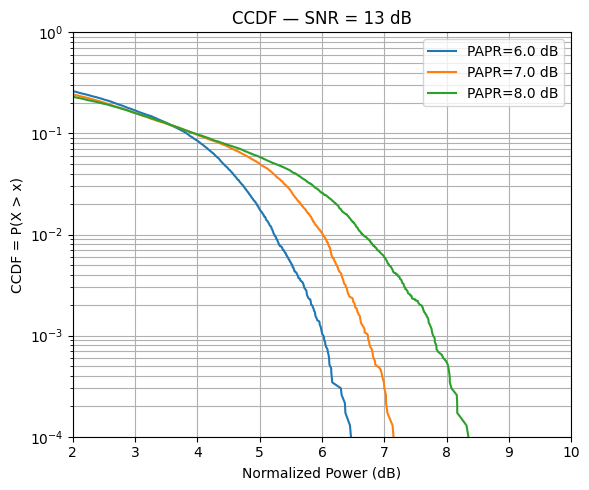

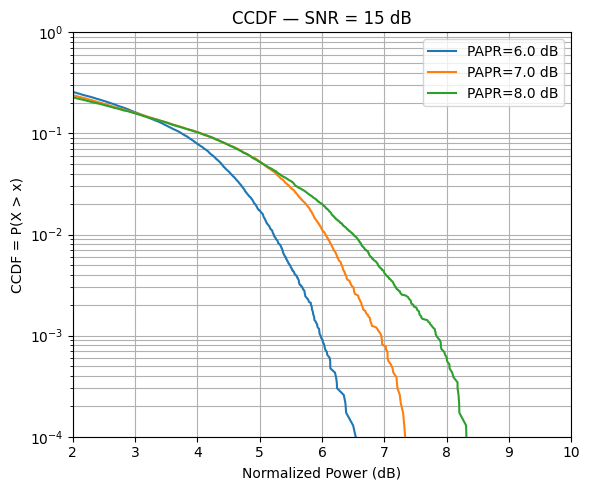

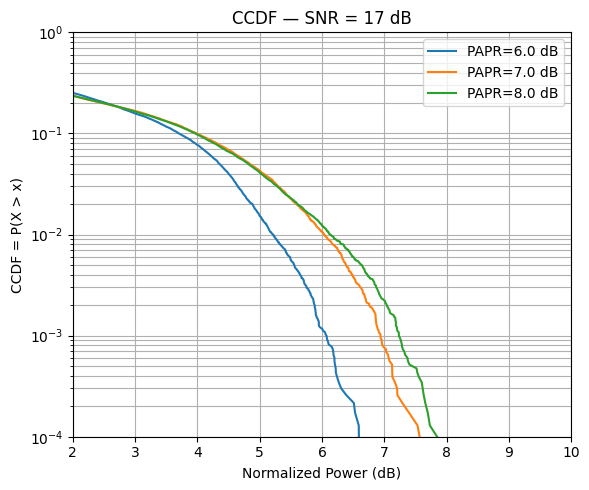

In [29]:
for snr_db in snr_list:

    plt.figure(figsize=(6, 5))

    for papr_db in papr_list:
        exp_name = f"snr_{snr_db}_papr_{papr_db}"
        data = np.load(f"{RESULTS_DIR}/{exp_name}.npz")

        x = data["ccdf_x_db"]
        y = data["ccdf_y"]

        plt.plot(x, y, label=f"PAPR={papr_db} dB")

    plt.yscale("log")
    plt.xlabel("Normalized Power (dB)")
    plt.ylabel("CCDF = P(X > x)")
    plt.title(f"CCDF — SNR = {snr_db} dB")
    plt.grid(True, which="both")
    plt.xlim(2, 10)
    plt.ylim(1e-4, 1)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/ccdf_snr_{snr_db}.png", dpi=300)
    plt.show()


### Plotting a single plot

In [ ]:
powers_ccdf = tf.reshape(model.compute_power_to_average_power_samples(),[-1])
powers_ccdf_db = 10*tf.math.log(powers_ccdf + 1e-12) / tf.math.log(10.)

# Sort data
x_sorted = np.sort(powers_ccdf_db.numpy())

# CCDF values
ccdf = 1.0 - np.arange(1, len(x_sorted) + 1) / len(x_sorted)

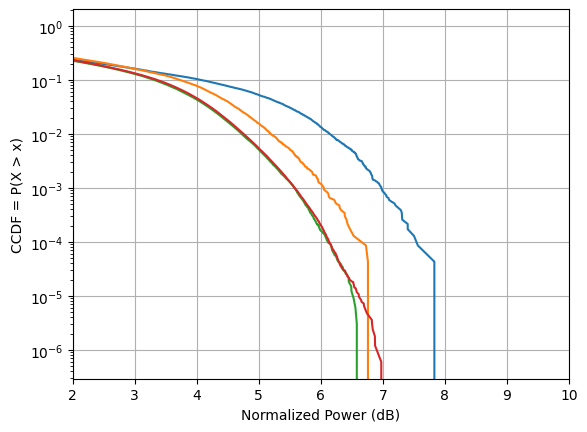

In [93]:
# Plot
plt.figure()
plt.plot(x_sorted, ccdf)
# plt.plot(x_sorted2, ccdf2)
# plt.plot(x_sorted3, ccdf3)
# plt.plot(x_sorted4, ccdf4)
plt.xlabel("Normalized Power (dB)")
plt.xlim(2,10)
plt.ylabel("CCDF = P(X > x)")
plt.yscale("log")   # optional, very common
plt.grid(True)
plt.show()


In [49]:
# Checking trainable parameters of the model

for v in model.trainable_weights:
    print(v.path, v.shape)

end_to_end_system_bitwise_11/sampling_mechanism_10/dense_38/kernel (1, 128)
end_to_end_system_bitwise_11/sampling_mechanism_10/dense_38/bias (128,)
end_to_end_system_bitwise_11/sampling_mechanism_10/dense_39/kernel (128, 16)
end_to_end_system_bitwise_11/sampling_mechanism_10/dense_39/bias (16,)
end_to_end_system_bitwise_11/modulator_6/constellation_real (64,)
end_to_end_system_bitwise_11/modulator_6/constellation_imag (64,)
end_to_end_system_bitwise_11/demodulator_bitwise_6/dense_40/kernel (3, 128)
end_to_end_system_bitwise_11/demodulator_bitwise_6/dense_40/bias (128,)
end_to_end_system_bitwise_11/demodulator_bitwise_6/dense_41/kernel (128, 128)
end_to_end_system_bitwise_11/demodulator_bitwise_6/dense_41/bias (128,)
end_to_end_system_bitwise_11/demodulator_bitwise_6/dense_42/kernel (128, 6)
end_to_end_system_bitwise_11/demodulator_bitwise_6/dense_42/bias (6,)
